In [1]:
import os
import numpy as np
import nibabel as nib

from mvlearn.embed import GCCA # To install: 
# git clone https://github.com/NeuroDataDesign/mvlearn.git
# cd mvlearn
# python setup.py install 

import matplotlib.pyplot as plt
%matplotlib inline
from nilearn.plotting import plot_surf_stat_map
from graspy.plot import pairplot

## Load Data

In [2]:
# load surfaces and cortex label

surf_lh = nib.freesurfer.read_geometry('/Applications/freesurfer/subjects/fsaverage5/surf/lh.inflated')
surf_rh = nib.freesurfer.read_geometry('/Applications/freesurfer/subjects/fsaverage5/surf/rh.inflated')

cort_lh = nib.freesurfer.read_label('/Applications/freesurfer/subjects/fsaverage5/label/lh.cortex.label')
cort_rh = nib.freesurfer.read_label('/Applications/freesurfer/subjects/fsaverage5/label/rh.cortex.label')
cort = np.concatenate((cort_lh, cort_rh+10242))

In [3]:
# load subject timeseries

# Example data available for nine subjects here: 
# https://www.dropbox.com/sh/rotu9742d5vkm18/AACmfzJDajKEzxgzPDZ-ysEda?dl=0

# As in example above, data should be loaded as single array of nodes x time points 
# already preprocessed, spatially smoothed (note that example data hasn't been smoothed),
# and with nuisance regresssion (but without global signal regression)

data = []
subjs = ['010005','010017','010018','010021','010024','010032','010042','010056','010060']
for s in subjs:
    data.append(np.load('/Users/dmargulies/Dropbox/02_data/LSD/rs_data/timeseries.sub-%s.npy' % s))
print(np.shape(data))

(9, 18715, 2608)


## Run GCCA

In [4]:
gcca = GCCA() # or specify another thresholding eg, n_components=5 or fraction_var=0.8
# Still not sure about that parameter selection

gcca.fit(data)
projs = gcca.transform(data)

print(gcca.ranks_)
print(np.shape(projs))

[6, 8, 6, 7, 5, 7, 7, 8, 6]
(9, 18715, 5)


In [5]:
np.save('gcca_results.npy', projs)

## Visualize results

In [23]:
# set visualization parameters:

n_comps = np.shape(projs)[2]
if n_comps > 5: # set max number of components to show at 5
    n_comps = 5

n_subs = np.shape(projs)[0]

n_views = 4 # number of brains to show per component
fig_width = 10

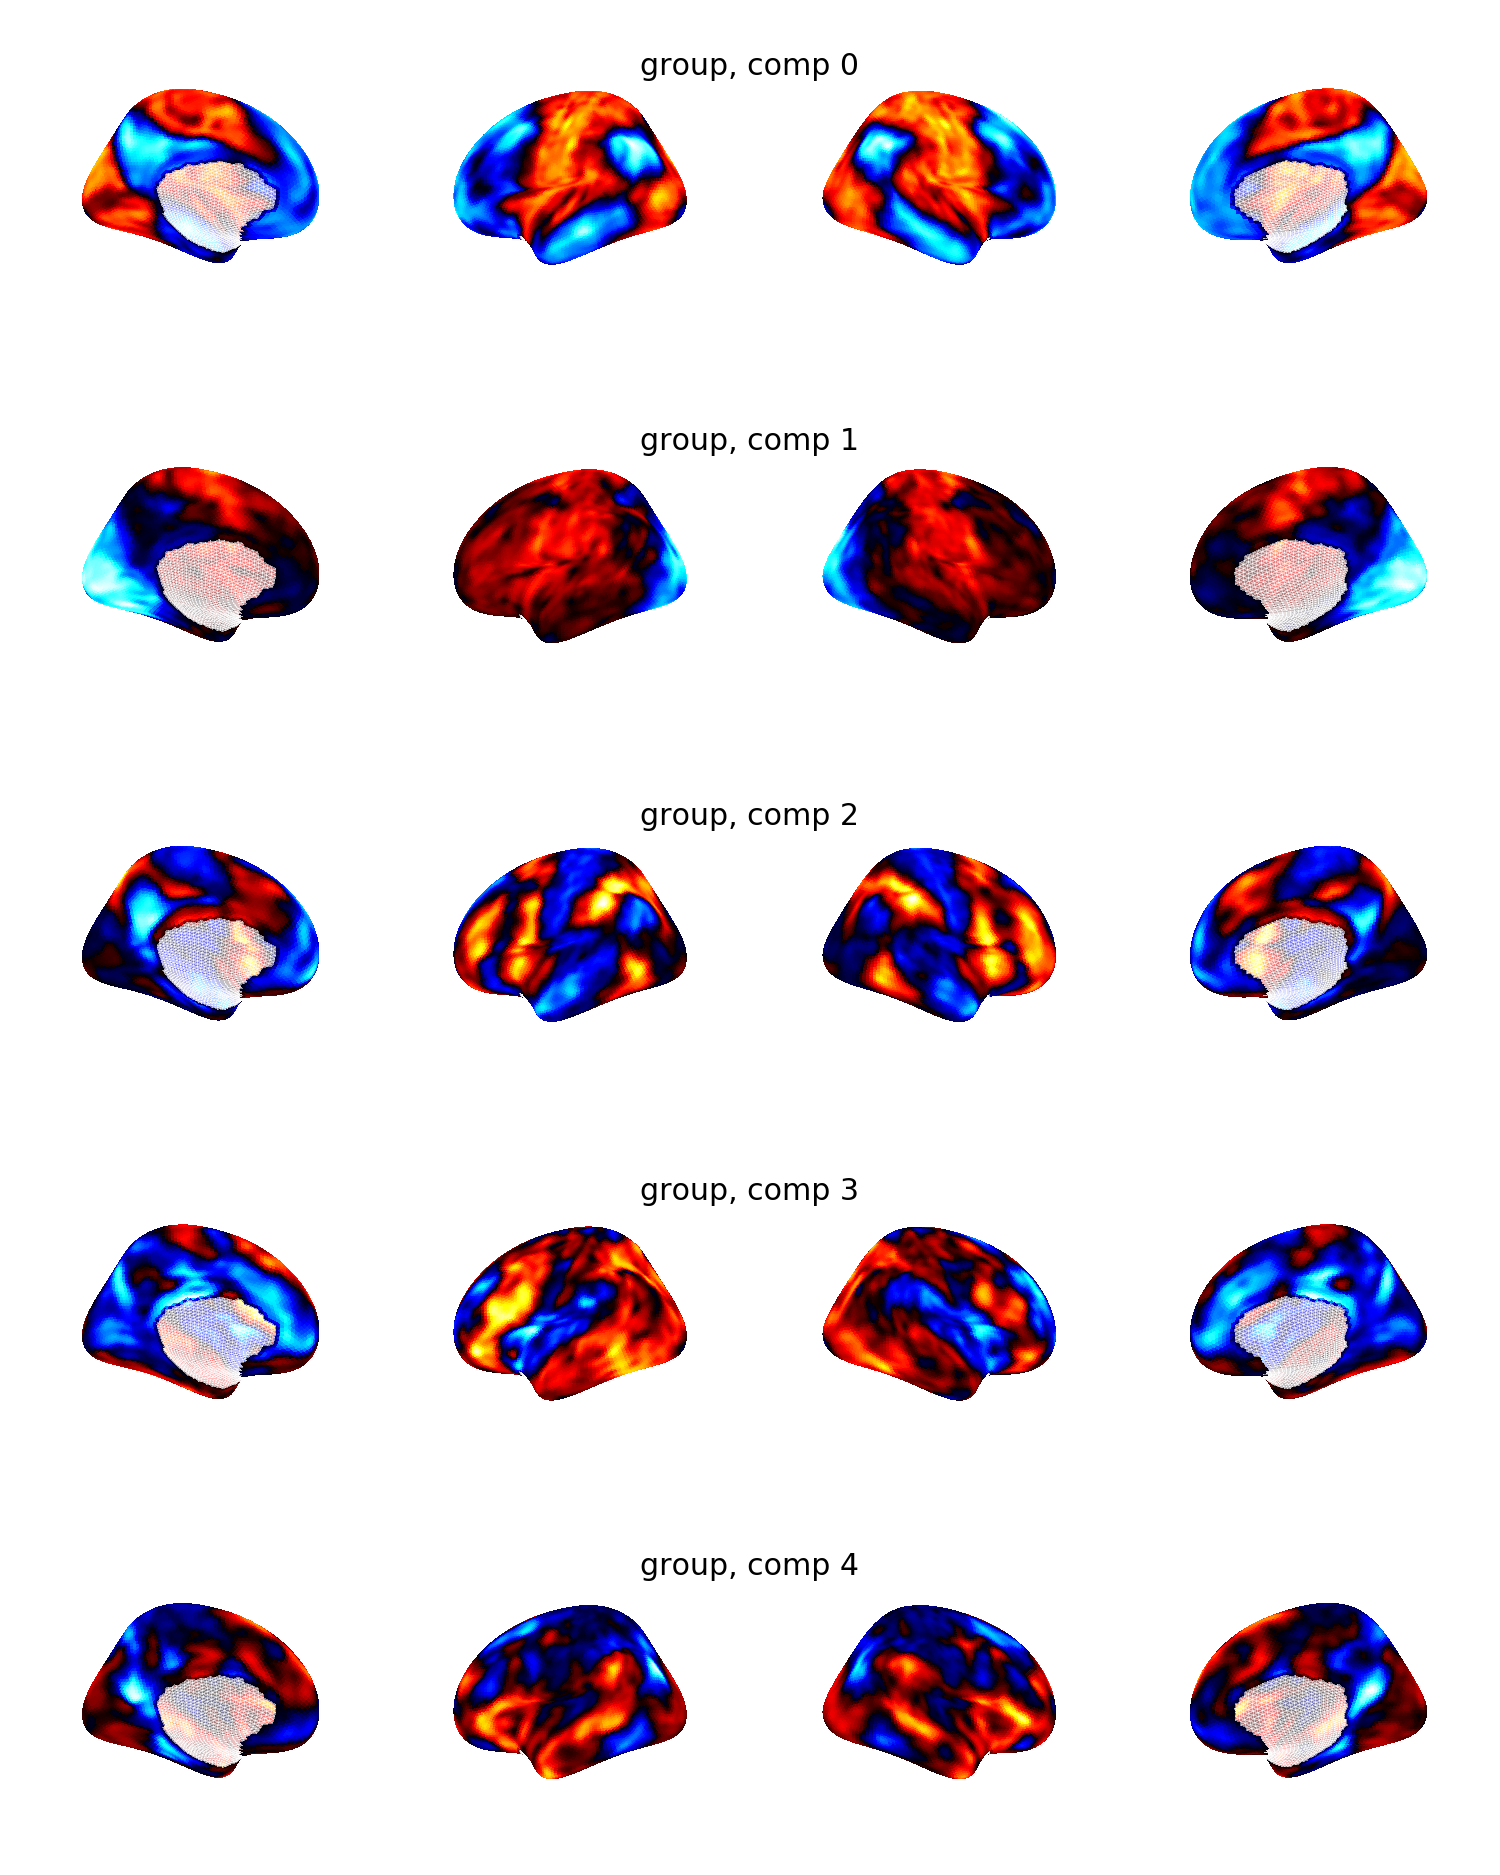

In [10]:
# Visualize group-level average components

fig = plt.figure(figsize=(fig_width, fig_width * n_comps * 0.25), dpi=72)

for component in range(n_comps):

    ax1 = fig.add_subplot(n_comps, n_views, component*n_views+1, projection='3d')
    ax2 = fig.add_subplot(n_comps, n_views, component*n_views+2, projection='3d')
    ax3 = fig.add_subplot(n_comps, n_views, component*n_views+3, projection='3d')
    ax4 = fig.add_subplot(n_comps, n_views, component*n_views+4, projection='3d')

    # left hemi
    res = np.zeros(10242)
    res[cort_lh] = np.mean(np.asarray(projs)[:,:len(cort_lh),component], axis=0)
    plot_surf_stat_map(surf_lh, res, hemi='left', view='medial', axes=ax1, colorbar=False)
    plot_surf_stat_map(surf_lh, res, hemi='left', view='lateral',  axes=ax2, colorbar=False)

    # right hemi
    res = np.zeros(10242)
    res[cort_rh] = np.mean(np.asarray(projs)[:,len(cort_lh):,component], axis=0)
    plot_surf_stat_map(surf_rh, res, hemi='right', view='lateral', axes=ax3, colorbar=False)
    plot_surf_stat_map(surf_rh, res, hemi='right', view='medial',  axes=ax4, colorbar=False)

    plt.figtext(0.5,0.96-(1./n_comps)*component,'group, comp %i' % component, 
                horizontalalignment='center', fontsize='x-large')

plt.tight_layout()
plt.subplots_adjust(hspace = 0.2)
filename = 'group.png'
plt.savefig(filename, dpi=150)
plt.show()

In [ ]:
# Visualize individual-level components

# to visualize other components, change the following variable:
component = 0

fig = plt.figure(figsize=(fig_width, fig_width * n_subs * 0.25), dpi=72)

for sub in range(len(projs)):
    
    ax1 = fig.add_subplot(n_subs, n_views, sub*n_views+1, projection='3d')
    ax2 = fig.add_subplot(n_subs, n_views, sub*n_views+2, projection='3d')
    ax3 = fig.add_subplot(n_subs, n_views, sub*n_views+3, projection='3d')
    ax4 = fig.add_subplot(n_subs, n_views, sub*n_views+4, projection='3d')

    # left hemi
    res = np.zeros(10242)
    res[cort_lh] = np.asarray(projs)[sub,:len(cort_lh),component]
    plot_surf_stat_map(surf_lh, res, hemi='left', view='medial',  axes=ax1, colorbar=False)
    plot_surf_stat_map(surf_lh, res, hemi='left', view='lateral', axes=ax2, colorbar=False)    
    
    # right hemi
    res = np.zeros(10242)
    res[cort_rh] = np.asarray(projs)[sub,len(cort_lh):,component]
    plot_surf_stat_map(surf_rh, res, hemi='right', view='lateral', axes=ax3, colorbar=False)
    plot_surf_stat_map(surf_rh, res, hemi='right', view='medial',  axes=ax4, colorbar=False)    
    
    plt.figtext(0.5,0.98-(1./n_subs)*sub,
                'sub %s, comp %i' % (subjs[sub],component), 
                horizontalalignment='center', fontsize='x-large')

plt.tight_layout()
plt.subplots_adjust(hspace = 0.2)
filename = 'individual_comp%i.png' % component
plt.savefig(filename, dpi=150)
plt.show()

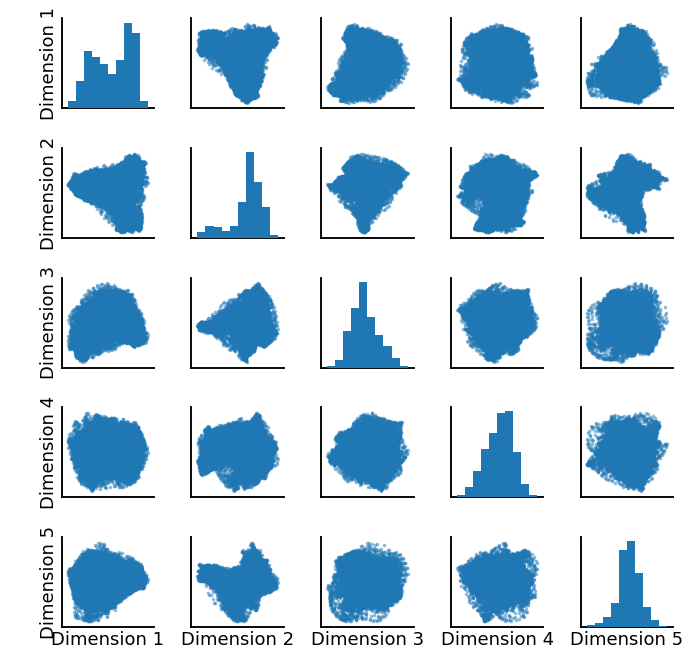

In [8]:
# Plot pairwise components for group averages

pairplot(np.mean(np.asarray(projs[:,:,:n_comps]), axis=0), height=2, alpha=0.5)

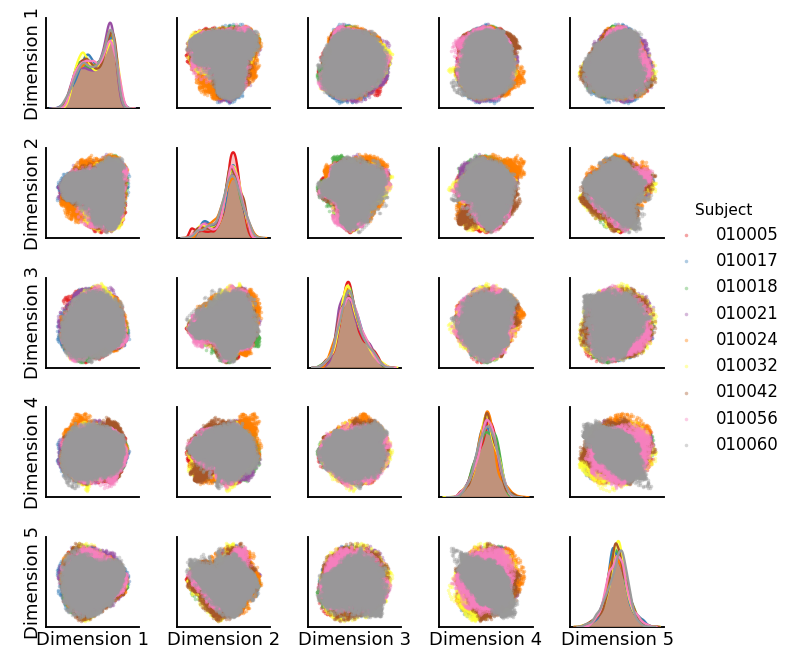

In [11]:
# Plot pairwise components across individuals

labels = []
for i in subjs:
    for j in range(projs[0].shape[0]):
        labels.append(i)

pairplot(np.vstack(projs[:,:,:n_comps]), labels=labels, height=2, 
         legend_name='Subject', alpha=0.4)

## Group-level analysis using PALM
https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/PALM/UserGuide

### 1. convert npy matrix to mgh filess

In [25]:
# write out .mgz files for all individuals:

projs = np.load('gcca_results.npy')

n_comps = np.shape(projs)[2]
if n_comps > 5: # set max number of components to show at 5
    n_comps = 5

for sub,sub_name in enumerate(subjs):
    for component in range(n_comps):
        for hemi in ['lh','rh']:
            res = np.zeros(10242).astype(np.float32)
            if hemi == 'lh':
                res[cort_lh] = np.asarray(projs)[sub,:len(cort_lh),component]
            elif hemi == 'rh':
                res[cort_rh] = np.asarray(projs)[sub,len(cort_lh):,component]
            img = nib.freesurfer.MGHImage(res, None)
            nib.save(img, 'data/%s.comp%i.%s.mgz' % (sub_name, component, hemi))            

In [32]:
# concatenate individual files into group-level

verbose = False

for component in range(n_comps):
    for hemi in ['lh','rh']:
        cmd = ["mri_concat"]
        for sub_name in subjs:
            cmd.append('data/%s.comp%i.%s.mgz' % (sub_name,component,hemi))
        cmd.append('--o data/group.comp%i.%s.mgz' % (component,hemi))
        if verbose:
            print(' '.join(cmd))
        os.system(' '.join(cmd))

### 2. create glm using mri_glmfit
https://surfer.nmr.mgh.harvard.edu/fswiki/FsTutorial/GroupAnalysis

Example:   

    mri_glmfit \    
      --y lh.gender_age.thickness.10.mgh \   
      --fsgd gender_age.fsgd dods\    
      --C lh-Avg-thickness-age-Cor.mtx \    
      --surf fsaverage lh \    
      --cortex \    
      --glmdir lh.gender_age.glmdir

Not necessary, but nevertheless...

#### To create contrast file:

    echo "0" > intercept.mtx
    
#### To create group-level file:
save file as: 'g1v0.fsgd'

    GroupDescriptorFile 1
    Title OSGM
    Class Main
    Input subject1 Main
    Input subject2 Main

In [35]:
for component in range(n_comps):
    for hemi in ['lh','rh']:
        cmd = ['mri_glmfit']
        cmd.append('--y data/group.comp%i.%s.mgz' % (component,hemi))
        cmd.append('--osgm')
        cmd.append('--fwhm 6')
        cmd.append('--surf fsaverage5 %s' % hemi)       
        cmd.append('--cortex')
        cmd.append('--glmdir results/%s.comp%i.glmdir' % (hemi,component))
        if verbose:
            print(' '.join(cmd))
        os.system(' '.join(cmd))

### 3. run palm using fspalm
http://freesurfer.net/fswiki/FsPalm  
https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/PALM

In [ ]:
verbose = True
execute = False

for component in range(n_comps):
    for hemi in ['lh','rh']:
        cmd = ['fspalm']
        cmd.append('--glmdir results/%s.comp%i.glmdir' % (hemi,component))
        cmd.append('--cft 1.3')
        cmd.append('--twotail')
        cmd.append('--name palm-twotail-1.3')
        cmd.append('--iters 1000')
        cmd.append('--2spaces')
        cmd.append('--cwp .05')
        cmd.append('--centroid')
        cmd.append('--pargs=\"-ise\"')
        cmd.append('--octave') 
        if verbose:
            print(' '.join(cmd))
        if execute:
            os.system(' '.join(cmd))

In [47]:
%%bash
fspalm --glmdir results/rh.comp0.glmdir --cft 1.3 --twotail --name palm-twotail-1.3 --iters 100 --2spaces --cwp .05 --centroid --pargs="-ise" --octave

             ___         ___                         ___
            /  /\       /  /\                       /__/\
           /  /::\     /  /::\                     |  |::\
          /  /:/\:\   /  /:/\:\    ___     ___     |  |:|:\
         /  /:/~/:/  /  /:/~/::\  /__/\   /  /\  __|__|:|\:\
        /__/:/ /:/  /__/:/ /:/\:\ \  \:\ /  /:/ /__/::::| \:\
        \  \:\/:/   \  \:\/:/__\/  \  \:\  /:/  \  \:\~~\__\/
         \  \::/     \  \::/        \  \:\/:/    \  \:\
          \  \:\      \  \:\         \  \::/      \  \:\
           \  \:\      \  \:\         \__\/        \  \:\
            \__\/       \__\/                       \__\/

                 Permutation Analysis of Linear Models
Running PALM alpha117 using Octave 5.1.0 with the following options:
-i /Users/dmargulies/Dropbox/01_code/meditation/notebooks/data/group.comp0.rh.mgz
-m /Users/dmargulies/Dropbox/01_code/meditation/notebooks/results/rh.comp0.glmdir/mask.mgh
-d design.mat
-t design.con
-logp
-n 100
-C 1.958920
-

    /Users/dmargulies/.octaverc at line 1 column 1
    /Users/dmargulies/.octaverc at line 2 column 1
/bin/sh: /Applications/freesurfer/bin/mri_surfcluster: cannot execute binary file


CalledProcessError: Command 'b'fspalm --glmdir results/rh.comp0.glmdir --cft 1.3 --twotail --name palm-twotail-1.3 --iters 100 --2spaces --cwp .05 --centroid --pargs="-ise" --octave\n'' returned non-zero exit status 126.